# 02 - Feature Engineering


In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PROCESSED, OUTPUTS_PLOTS, DATASET
from src.preprocessing import (
    compute_rul, 
    remove_low_variance_features, 
    add_features,
    remove_low_corr_features
)
OUTPUTS_PLOTS.mkdir(parents=True, exist_ok=True)

## 1 - Feature Engineering

- RUL (number of remaining cycles before engine failure) computation :

RUL = max_cycles - time_cycles

- Clipping at 120 cycles: beyond this value, the engine is considered to be in good health, and prediction accuracy has no operational relevance (maintenance is not scheduled 300 cycles in advance) + standard in the CMAPSS literature.

- Low-variance feature removal — sensors with near-zero variance (<1e-5) carry no information

- Temporal features per engine (window=5): rolling mean, rolling std, first-order difference

- Correlation filtering — features with |corr(RUL)| ≤ 0.1 removed

In [2]:
df = pd.read_csv(DATA_PROCESSED/"train_FD001_clean.csv")
df['RUL']=compute_rul(df)
df_clean = remove_low_variance_features(df)
df_clean = add_features(df_clean)
df_model = remove_low_corr_features(df_clean)
df_model.to_csv(DATA_PROCESSED/"train_FD001_features.csv", index=False)

## 2 - Insightful plots

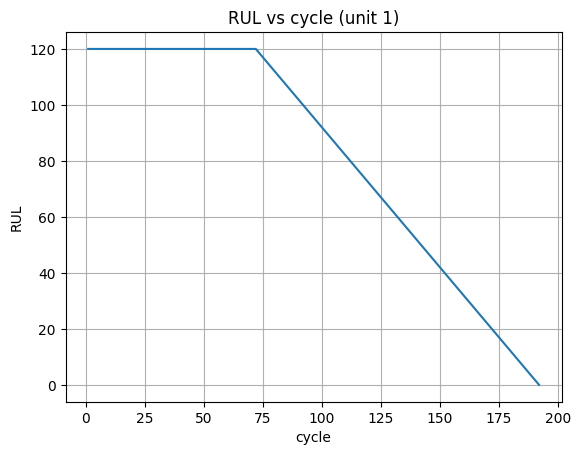

In [3]:
#Plots

u1 = df[df['unit_number']==1]

plt.plot(u1['time_cycles'], u1['RUL'])
plt.title('RUL vs cycle (unit 1)')
plt.xlabel('cycle')
plt.ylabel('RUL')
plt.grid()
plt.savefig(OUTPUTS_PLOTS/f'02_rul_unit_1_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

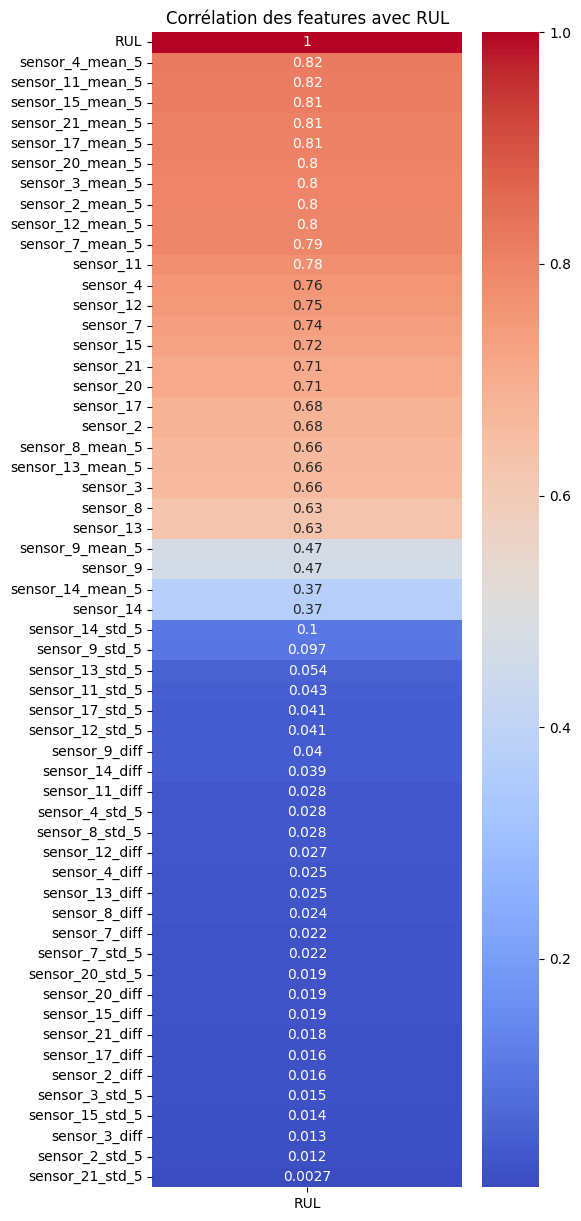

In [4]:
cols = [c for c in df_clean.columns if "sensor" in c or "setting" in c]
corr = df_clean[cols+['RUL']].corr()['RUL'].abs().sort_values(ascending=False)

plt.figure(figsize=(5,15))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Corrélation des features avec RUL')
plt.savefig(OUTPUTS_PLOTS/f'02_rul_corr_heatmap_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

RUL vs top 10 correlated features scatterplot

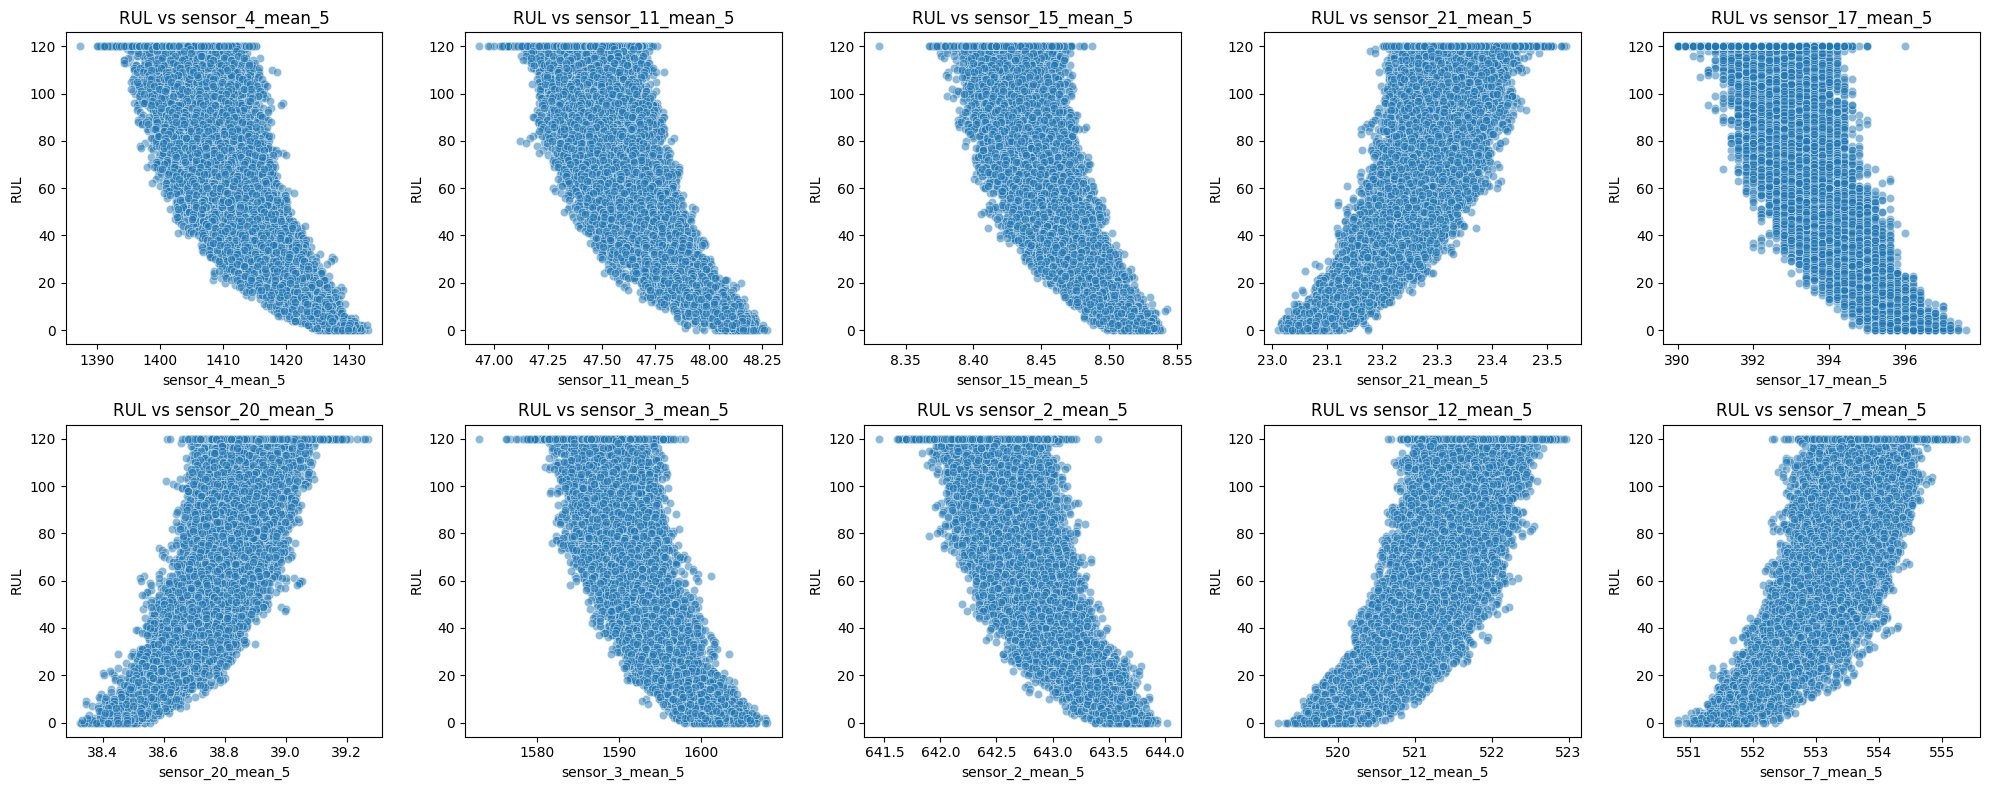

In [5]:
sample_features = corr.index[1:11]
sample_units = df_clean['unit_number'].unique()[:5]

fig, axes = plt.subplots(2, 5, figsize=(20,8))  
axes = axes.flatten()

for ax, feature in zip(axes, sample_features):
    sns.scatterplot(x=df_clean[feature], y=df_clean['RUL'], alpha=0.5, ax=ax)
    ax.set_title(f'RUL vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('RUL')

plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS/f'02_rul_vs_top10_features_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

We visualize the evolution of the top features over cycles for 5 different engines.
The convergence of the curves toward the end of life is the key signal that the models should learn.

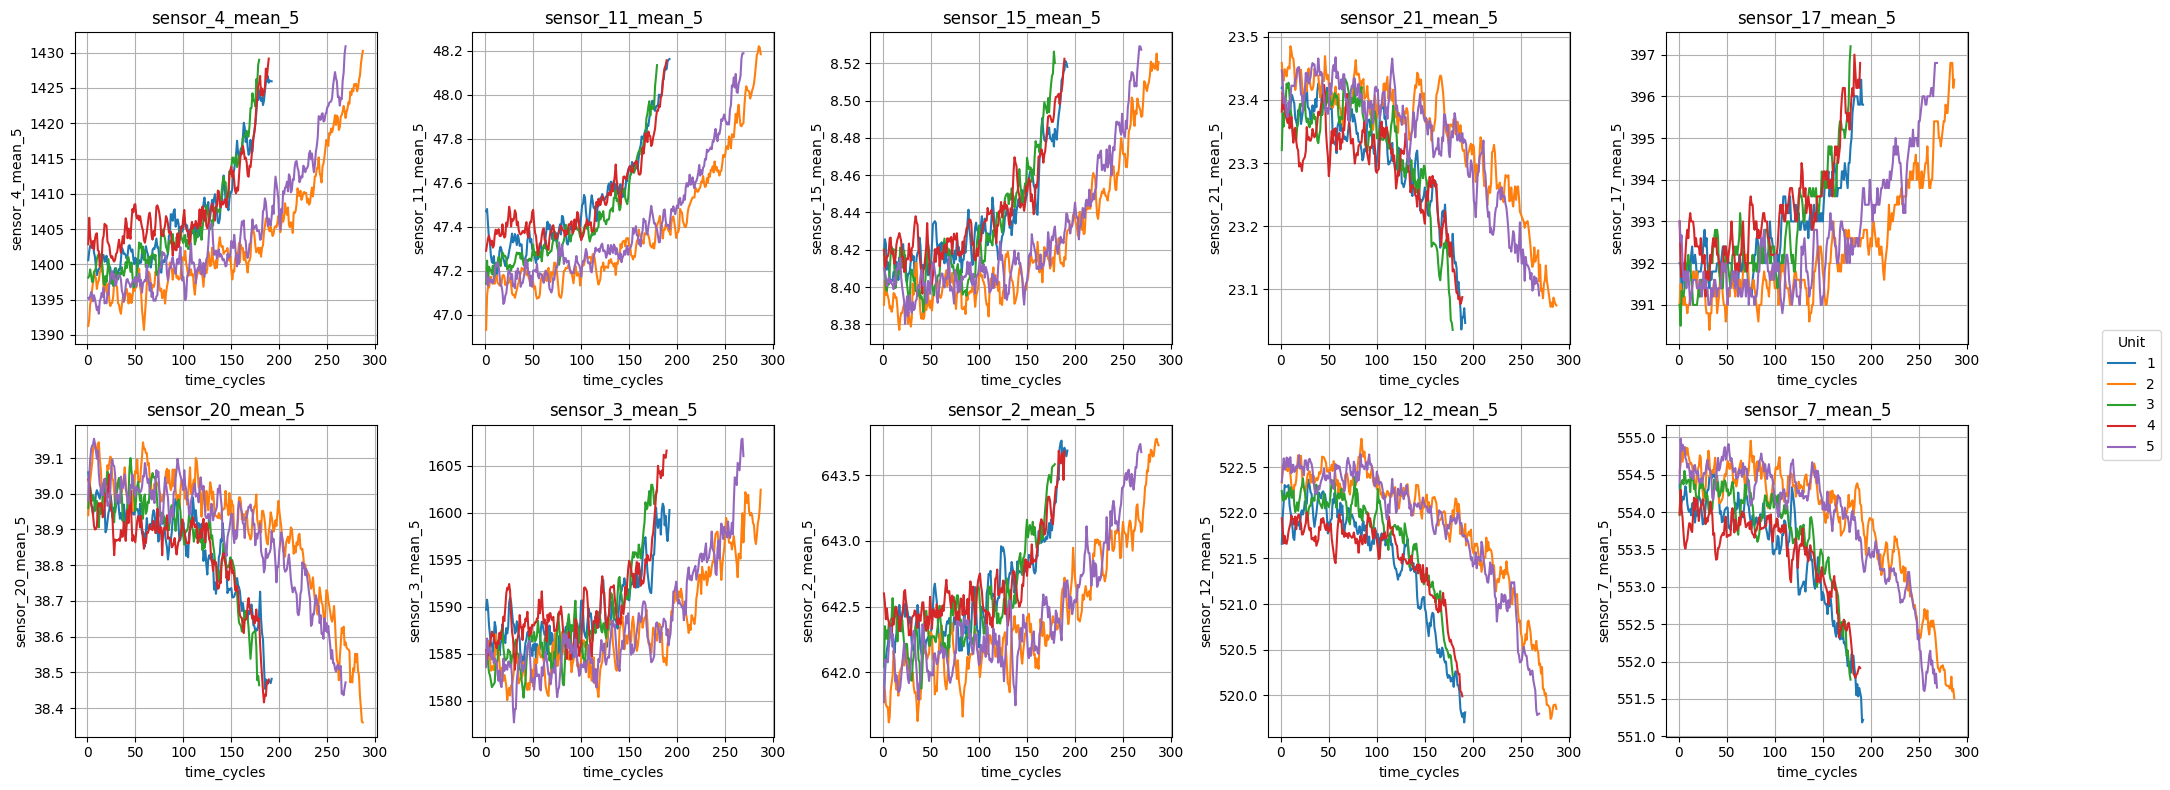

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(20,8))
axes = axes.flatten()

for ax, feature in zip(axes, sample_features):
    for unit in sample_units:
        subset = df_clean[df_clean['unit_number']==unit]
        ax.plot(subset['time_cycles'], subset[feature], label=f'Unit {unit}')
    ax.set_title(feature)
    ax.set_xlabel('time_cycles')
    ax.set_ylabel(feature)
    ax.grid(True)

fig.legend(sample_units, title='Unit', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS/f'02_features_over_time_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()